In [20]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras import preprocessing 

# Define sub_folder classes & base_path

In [21]:
classes = ['Gloves', 'Hand', 'Me']
base_path = '/Users/Disalo/SPICED/euclidean_eukalyptus/payam_work/Week_09/imageclassifier/data/'

# Define an image data generator

In [22]:
data_gen = preprocessing.image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=mobilenet_v2.preprocess_input,
     #rotation_range=20,
     #width_shift_range=0.2,
     #height_shift_range=0.2,
     #horizontal_flip=True, 
     #vertical_flip=True,
     # zoom_range=0.2,
     shear_range=0.2)

# A generator that returns batches of X and y arrays

In [23]:
train_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=30,
        target_size=(224, 224)
)

Found 308 images belonging to 3 classes.


# Load in all images at once

In [24]:
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((30, 224, 224, 3), (30, 3))

# Define a function to plot batch of images

In [25]:
def plotImages(images_arr):
    fig, axes = plt.subplots(6, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

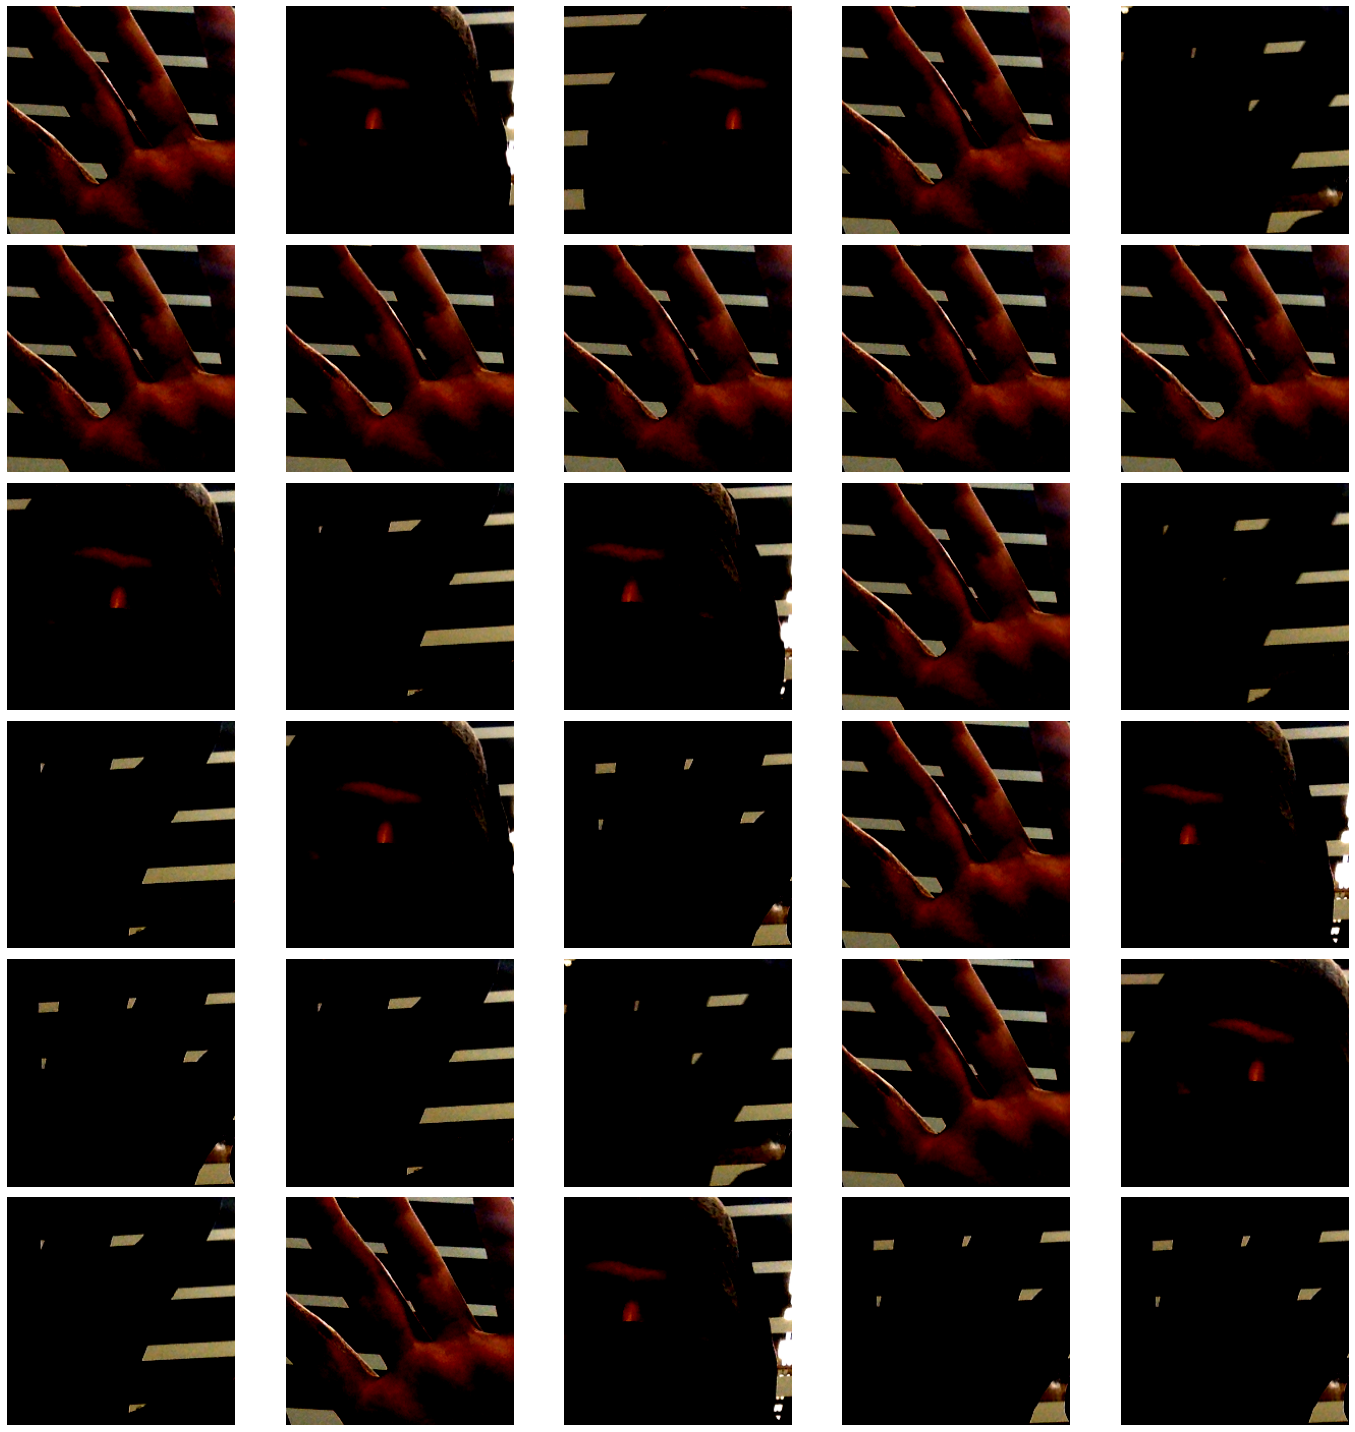

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [26]:
plotImages(xtrain)
print(ytrain)

# Check the classes & if they are categorized

In [27]:
classes

['Gloves', 'Hand', 'Me']

In [28]:
ytrain

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

# Hire base model from MobileNetV2

In [29]:
base_model = mobilenet_v2.MobileNetV2(
    weights='imagenet', 
    alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # !!!!! we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

# Not to train base model again

In [30]:
base_model.trainable = False

# Freez or keep convolution layers of the base model and re-structre the dense layers

In [31]:
model = keras.Sequential()
model.add(base_model)
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(classes), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
# have a look at the trainable and non-trainable params statistic
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.35_224 (Functi (None, 1280)              410208    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               128100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 538,611
Trainable params: 128,403
Non-trainable params: 410,208
_________________________________________________________________


# Compile & Fit the model

In [32]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

# observe the validation loss and stop when it does not improve after 3 iterations
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(xtrain, ytrain, 
          epochs=50, 
          verbose=2,
          callbacks=[callback],
          validation_split=0.3)

Epoch 1/50
1/1 - 5s - loss: 1.4927 - categorical_accuracy: 0.3810 - val_loss: 0.7788 - val_categorical_accuracy: 0.4444
Epoch 2/50
1/1 - 1s - loss: 0.6852 - categorical_accuracy: 0.6667 - val_loss: 0.2949 - val_categorical_accuracy: 1.0000
Epoch 3/50
1/1 - 0s - loss: 0.2644 - categorical_accuracy: 0.9524 - val_loss: 0.1167 - val_categorical_accuracy: 1.0000
Epoch 4/50
1/1 - 0s - loss: 0.0904 - categorical_accuracy: 1.0000 - val_loss: 0.0524 - val_categorical_accuracy: 1.0000
Epoch 5/50
1/1 - 0s - loss: 0.0686 - categorical_accuracy: 1.0000 - val_loss: 0.0276 - val_categorical_accuracy: 1.0000
Epoch 6/50
1/1 - 0s - loss: 0.0256 - categorical_accuracy: 1.0000 - val_loss: 0.0160 - val_categorical_accuracy: 1.0000
Epoch 7/50
1/1 - 0s - loss: 0.0268 - categorical_accuracy: 1.0000 - val_loss: 0.0098 - val_categorical_accuracy: 1.0000
Epoch 8/50
1/1 - 0s - loss: 0.0458 - categorical_accuracy: 1.0000 - val_loss: 0.0062 - val_categorical_accuracy: 1.0000
Epoch 9/50
1/1 - 0s - loss: 0.0321 - cat

# Predict an image

['Gloves', 'Hand', 'Me']

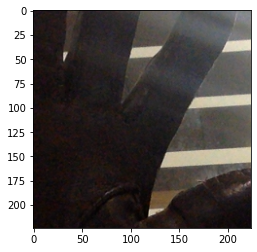

In [33]:
img = image.load_img('15-22-14-189991 copy.png')
plt.imshow(img)
img.size
a = image.img_to_array(img)
a = np.expand_dims(a, axis = 0)
a.shape
model.predict(a)
model.predict(a)[0].round(decimals = 3)
classes

<BarContainer object of 3 artists>

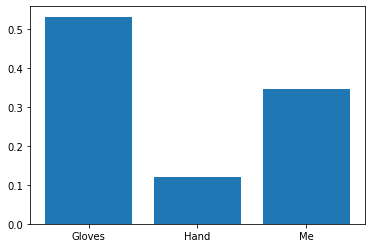

In [34]:
plt.bar(x = classes, height = model.predict(a)[0])

In [35]:
model.save('/Users/Disalo/SPICED/euclidean_eukalyptus/payam_work/Week_09/imageclassifier/models/Transfer_Learning_model.h5')